In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
gds = xr.open_zarr("work/ufs2arco/tests/features/gfs-annual-1/dataset.zarr", decode_timedelta=True)
hds = xr.open_zarr("work/ufs2arco/tests/features/hrrr-annual-1/dataset.zarr", decode_timedelta=True)

In [3]:
gds.attrs["label"] = "GFS"
hds.attrs["label"] = "HRRR"

### Test over fhr

In [4]:
for xds in [gds, hds]:
    for key in ["lsm", "orog"]:
        print(f"{xds.label} {key}: {(np.abs(xds[key].diff('fhr')) > 0).any().values}")

GFS lsm: False
GFS orog: False
HRRR lsm: True
HRRR orog: False


### Compare over t0

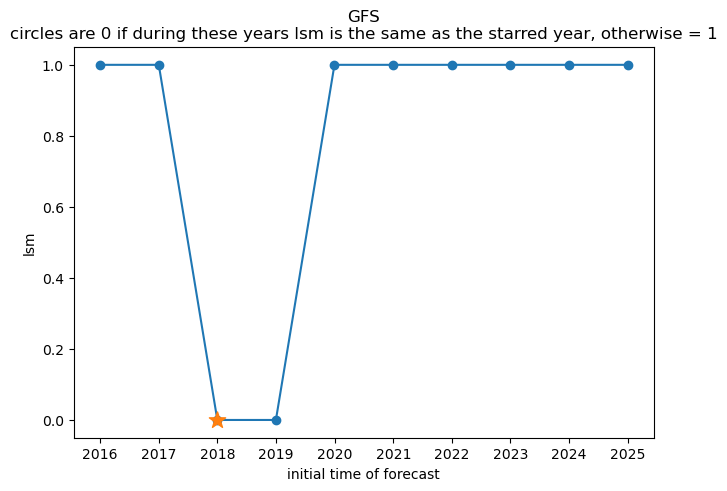

In [5]:
ds = gds.sel(fhr=0)
key = "lsm"
itime = 2
fig, ax = plt.subplots(constrained_layout=True)
(np.abs(ds[key] - ds[key].isel(t0=itime)) > 0).any(["latitude", "longitude"]).plot.line(x="t0", marker="o", ax=ax)
ax.scatter(ds.t0.isel(t0=itime), 0, s=150, zorder=3, marker="*", color="C1" )#, s=5)
plt.title(f"{ds.label}\ncircles are 0 if during these years {key} is the same as the starred year, otherwise = 1");

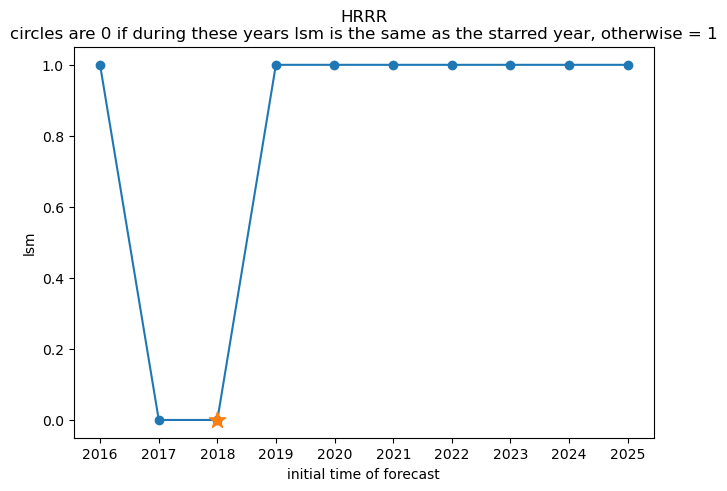

In [6]:
ds = hds.sel(fhr=0)
key = "lsm"
itime = 2
fig, ax = plt.subplots(constrained_layout=True)
(np.abs(ds[key] - ds[key].isel(t0=itime)) > 0).any(["y", "x"]).plot.line(x="t0", marker="o", ax=ax)
ax.scatter(ds.t0.isel(t0=itime), 0, s=150, zorder=3, marker="*", color="C1" )#, s=5)
plt.title(f"{ds.label}\ncircles are 0 if during these years {key} is the same as the starred year, otherwise = 1");

In [7]:
diff = (ds[key] - ds[key].isel(t0=itime))

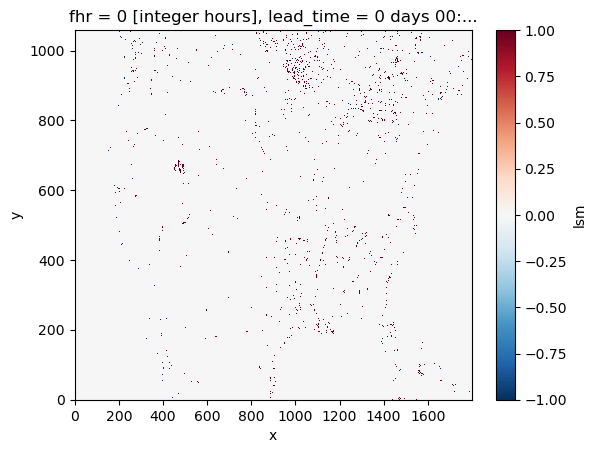

In [8]:
diff.isel(t0=4).plot()

In [41]:
(np.abs(hds.lsm.diff("fhr")) > 0).any(["x", "y"]).compute()

<xarray.DataArray 'lsm' (t0: 10, fhr: 1)> Size: 10B
array([[False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True]])
Coordinates:
  * fhr         (fhr) int64 8B 6
    lead_time   (fhr) timedelta64[ns] 8B NaT
  * t0          (t0) datetime64[ns] 80B 2015-12-31 2016-12-31 ... 2024-12-31
    valid_time  (t0, fhr) datetime64[ns] 80B NaT NaT NaT NaT ... NaT NaT NaT NaT

### Digging into LSM differences in HRRR

In [14]:
from ufs2arco import sources

In [42]:
hrrr = sources.AWSHRRRArchive(
    t0={"start": "2020-12-31T00", "end": "2021-12-31T00", "freq": "1YE"},
    fhr={"start": 0, "end": 6, "step": 1},
)

In [43]:
dslist = []
for t0 in hrrr.t0:
    for fhr in hrrr.fhr:
        xds = hrrr.open_grib(
           dims={"t0": t0, "fhr": fhr},
           file_suffix="sfc",
           cache_dir="./gribcache",
           filter_by_keys={
               "typeOfLevel": "surface",
               "stepType": "instant",
           },
       )
        dslist.append(xds)

ERROR! Session/line number was not unique in database. History logging moved to new session 2309


In [44]:
xds = xr.combine_by_coords(
    [xx.drop_vars(["latitude", "longitude"]) for xx in dslist],
    combine_attrs="drop",
)

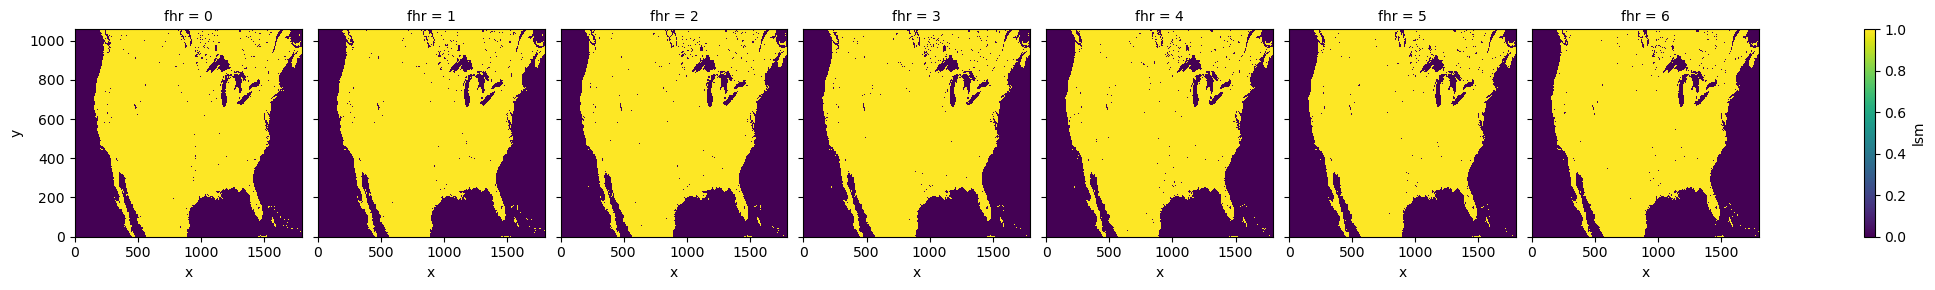

In [45]:
xds.lsm.isel(t0=-1).plot(col="fhr")

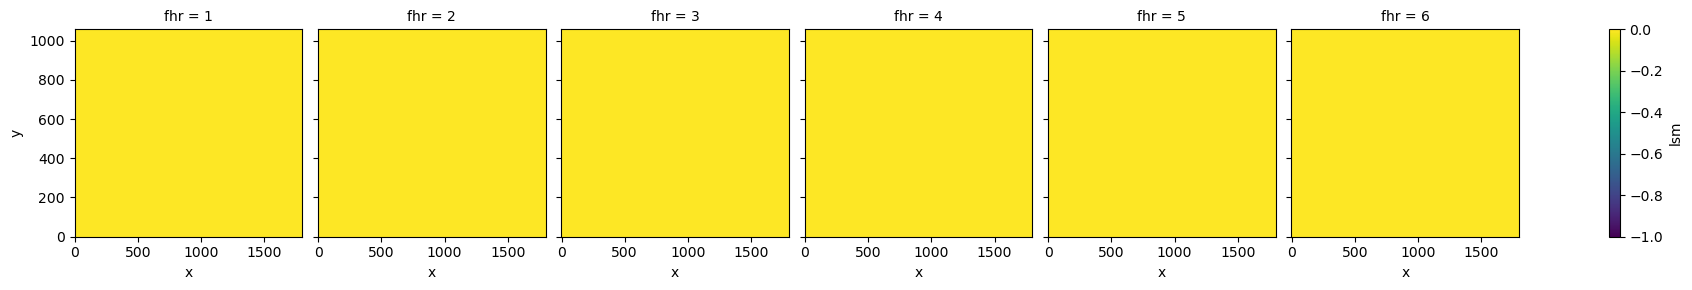

In [47]:
xds.lsm.isel(t0=0).diff("fhr").plot(col="fhr")

In [49]:
np.abs(xds.lsm.diff("fhr")).max(["x", "y"])

<xarray.DataArray 'lsm' (t0: 2, fhr: 6)> Size: 48B
array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)
Coordinates:
  * t0          (t0) datetime64[ns] 16B 2020-12-31 2021-12-31
    lead_time   (fhr) timedelta64[ns] 48B 01:00:00 02:00:00 ... 06:00:00
    surface     float64 8B 0.0
  * fhr         (fhr) int64 48B 1 2 3 4 5 6
    valid_time  (t0, fhr) datetime64[ns] 96B 2020-12-31T01:00:00 ... 2021-12-...

In [51]:
mask = (np.abs(xds.lsm.diff("fhr"))>0).any("fhr")

In [54]:
xds.lsm.where(mask).sum(["x", "y"]).compute()

<xarray.DataArray 'lsm' (t0: 2, fhr: 7)> Size: 56B
array([[1., 1., 1., 1., 1., 1., 0.],
       [3., 0., 0., 0., 0., 0., 0.]], dtype=float32)
Coordinates:
  * t0          (t0) datetime64[ns] 16B 2020-12-31 2021-12-31
    lead_time   (fhr) timedelta64[ns] 56B 00:00:00 01:00:00 ... 06:00:00
    surface     float64 8B 0.0
  * fhr         (fhr) int64 56B 0 1 2 3 4 5 6
    valid_time  (t0, fhr) datetime64[ns] 112B 2020-12-31 ... 2021-12-31T06:00:00

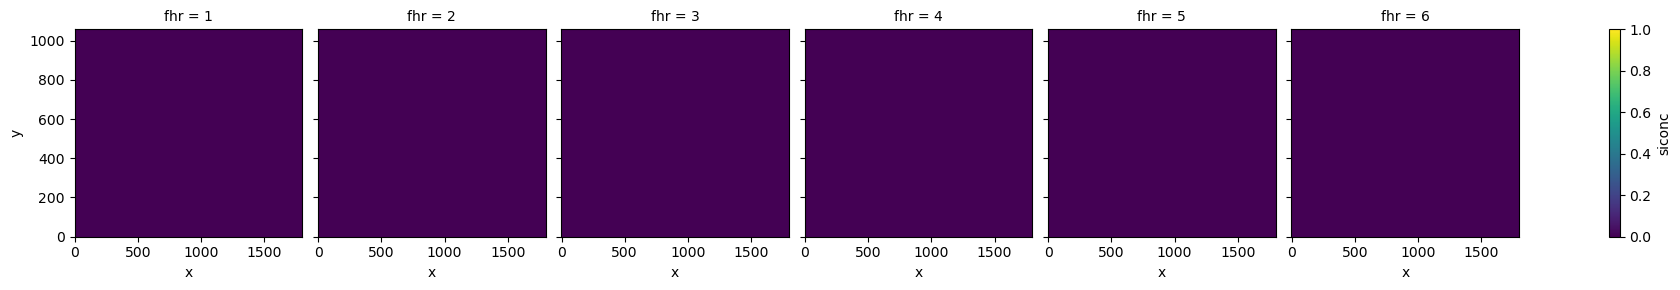

In [58]:
(np.abs(xds.siconc.isel(t0=0).diff("fhr"))>0).plot(col="fhr")

In [57]:
(np.abs(xds.siconc.diff("fhr"))>0).sum(["x", "y"])

<xarray.DataArray 'siconc' (t0: 2, fhr: 6)> Size: 96B
array([[4, 2, 2, 1, 3, 4],
       [2, 5, 1, 3, 6, 5]])
Coordinates:
  * t0          (t0) datetime64[ns] 16B 2020-12-31 2021-12-31
    lead_time   (fhr) timedelta64[ns] 48B 01:00:00 02:00:00 ... 06:00:00
    surface     float64 8B 0.0
  * fhr         (fhr) int64 48B 1 2 3 4 5 6
    valid_time  (t0, fhr) datetime64[ns] 96B 2020-12-31T01:00:00 ... 2021-12-...

### Some quick verification that LSM now has just t0 as time coordinate

In [72]:
bb = xr.open_zarr("work/ufs2arco/tests/features/hrrr-lsm/dataset.zarr/", decode_timedelta=True)

In [73]:
bb

<xarray.Dataset> Size: 76MB
Dimensions:     (fhr: 2, t0: 2, pressure: 1, y: 1059, x: 1799)
Coordinates:
  * fhr         (fhr) int64 16B 0 6
    latitude    (y, x) float64 15MB dask.array<chunksize=(133, 450), meta=np.ndarray>
    lead_time   (fhr) timedelta64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    longitude   (y, x) float64 15MB dask.array<chunksize=(133, 450), meta=np.ndarray>
  * pressure    (pressure) float64 8B 500.0
  * t0          (t0) datetime64[ns] 16B 2015-12-31 2016-12-31
    valid_time  (t0, fhr) datetime64[ns] 32B dask.array<chunksize=(2, 2), meta=np.ndarray>
  * x           (x) int64 14kB 0 1 2 3 4 5 6 ... 1793 1794 1795 1796 1797 1798
  * y           (y) int64 8kB 0 1 2 3 4 5 6 ... 1053 1054 1055 1056 1057 1058
Data variables:
    gh          (t0, fhr, pressure, y, x) float32 30MB dask.array<chunksize=(1, 1, 1, 1059, 1799), meta=np.ndarray>
    lsm         (t0, y, x) float32 15MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    description:             This is a test dataset
    latest_write_timestamp:  2025-06-05T16:49:06
    recipe:                  {'attrs': {'description': 'This is a test datase...

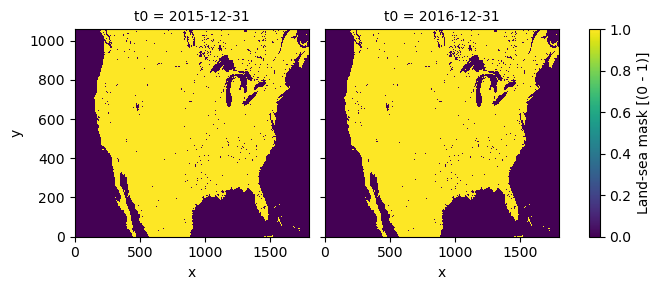

In [74]:
bb.lsm.plot(col="t0")

In [63]:
xds = hrrr.open_grib(
   dims={"t0": hrrr.t0[0], "fhr": hrrr.fhr[0]},
   file_suffix="sfc",
   cache_dir="./gribcache",
   filter_by_keys={
       "typeOfLevel": "isobaricInhPa",
       "paramId": 156,
   },
)

In [64]:
xds

<xarray.Dataset> Size: 61MB
Dimensions:     (t0: 1, fhr: 1, level: 4, y: 1059, x: 1799)
Coordinates:
  * t0          (t0) datetime64[ns] 8B 2020-12-31
    lead_time   (fhr) timedelta64[ns] 8B 00:00:00
  * level       (level) float64 32B 1e+03 850.0 700.0 500.0
    latitude    (y, x) float64 15MB ...
    longitude   (y, x) float64 15MB ...
  * fhr         (fhr) int64 8B 0
    valid_time  (t0, fhr) datetime64[ns] 8B 2020-12-31
Dimensions without coordinates: y, x
Data variables:
    gh          (t0, fhr, level, y, x) float32 30MB 175.8 175.8 ... 5.373e+03
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-05T16:39 GRIB to CDM+CF via cfgrib-0.9.1...